In [ ]:
# !kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set
# !unzip /content/cartoon-faces-googles-cartoon-set.zip

In [ ]:
# !kaggle datasets download -d splcher/animefacedataset
# !unzip /content/animefacedataset.zip

In [15]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [18]:
# Define paths
anime_faces_folder = '/kaggle/input/animefacedataset/images'
cartoon_faces_base_folder = '/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg'

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load half of anime faces
anime_files = os.listdir(anime_faces_folder)
random.shuffle(anime_files)
anime_files = anime_files[:len(anime_files)//2]
anime_images = [os.path.join(anime_faces_folder, f) for f in anime_files]
anime_labels = [0] * len(anime_images)

# Randomly select 5 folders of cartoon faces
cartoon_folders = os.listdir(cartoon_faces_base_folder)
selected_folders = random.sample(cartoon_folders, 5)
cartoon_images = []
cartoon_labels = []
for folder in selected_folders:
    folder_path = os.path.join(cartoon_faces_base_folder, folder)
    files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(files)
    half_files = files[:len(files)//2]
    for filename in half_files:
        cartoon_images.append(os.path.join(folder_path, filename))
        cartoon_labels.append(1)

# Combine datasets
all_images = anime_images + cartoon_images
all_labels = anime_labels + cartoon_labels

# Create dataset and dataloader
dataset = ImageDataset(image_paths=all_images, labels=all_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [19]:
len(anime_images)

31782

In [20]:
# print(all_images_tensor.shape)

In [21]:
# ResNet Block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [22]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Encoder, self).__init__()
        self.num_classes = num_classes
        
        self.block1 = ResNetBlock(3, 32, stride=2)
        self.block2 = ResNetBlock(32, 64, stride=2)
        self.fc_mean = nn.Linear(64 * 16 * 16 + num_classes, latent_dim)
        self.fc_log_var = nn.Linear(64 * 16 * 16 + num_classes, latent_dim)

    def forward(self, x, y):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        
        # Concatenate with labels
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        x = torch.cat([x, y_onehot], dim=1)
        
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean,log_var

In [24]:
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, mean, log_var):
        epsilon = torch.randn_like(mean)  # Sample from a normal distribution
        return mean + torch.exp(log_var / 2) * epsilon

In [25]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Decoder, self).__init__()
        self.num_classes = num_classes
        
        self.fc = nn.Linear(latent_dim + self.num_classes, 64 * 16 * 16)
        self.block1 = ResNetBlock(64, 32, stride=1)
        self.block2 = ResNetBlock(32, 3, stride=1)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, z, y):
        # Concatenate with labels
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        z = torch.cat([z, y_onehot], dim=1)
        
        x = self.fc(z)
        x = x.view(-1, 64, 16, 16)
        x = self.up1(x)
        x = self.block1(x)
        x = self.up2(x)
        x = self.block2(x)
        x_reconstructed = torch.sigmoid(x)
        x_reconstructed = x_reconstructed.view(-1, 3, 64, 64)
        return x_reconstructed

In [27]:
class CVAE(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.encoder = Encoder(latent_dim, num_classes)
        self.sampling = Sampling()
        self.decoder = Decoder(latent_dim, num_classes)

    def forward(self, x, y):
        # Encode
        mean, log_var = self.encoder(x, y)

        z = self.sampling(mean, log_var)

        # Decode
        recon_x = self.decoder(z, y)
        
        kl_loss = -0.5 * torch.mean(1 + log_var - mean.pow(2) - log_var.exp())

        return kl_loss, recon_x


In [29]:
# Initialize CVAE model
latent_dim = 128  # Adjust as per your choice
num_classes = 2   # Anime (0) and Cartoon (1)
model = CVAE(latent_dim, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
loss_ = []
r_l = []
kl_l = []
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        kl_loss, recon_x = model(x, y)
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
        loss = recon_loss + kl_loss

        loss_.append(loss)
        r_l.append(recon_loss)
        kl_l.append(kl_loss)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss / len(dataloader):.4f}")

# Save trained model
torch.save(model.state_dict(), 'cvae_model.pth')


Epoch [1/3], Batch [1/1775], Loss: 0.9033
Epoch [1/3], Batch [101/1775], Loss: 0.8108
Epoch [1/3], Batch [201/1775], Loss: 0.5918
Epoch [1/3], Batch [301/1775], Loss: 0.5056
Epoch [1/3], Batch [401/1775], Loss: 0.5027
Epoch [1/3], Batch [501/1775], Loss: 0.4526
Epoch [1/3], Batch [601/1775], Loss: 0.5416
Epoch [1/3], Batch [701/1775], Loss: 0.4567
Epoch [1/3], Batch [801/1775], Loss: 0.4568
Epoch [1/3], Batch [901/1775], Loss: 0.4393
Epoch [1/3], Batch [1001/1775], Loss: 0.4961
Epoch [1/3], Batch [1101/1775], Loss: 0.4775
Epoch [1/3], Batch [1201/1775], Loss: 0.4589
Epoch [1/3], Batch [1301/1775], Loss: 0.4446
Epoch [1/3], Batch [1401/1775], Loss: 0.4453
Epoch [1/3], Batch [1501/1775], Loss: 0.4120
Epoch [1/3], Batch [1601/1775], Loss: 0.4338
Epoch [1/3], Batch [1701/1775], Loss: 0.4305
Epoch [1/3], Total Loss: 0.9035
Epoch [2/3], Batch [1/1775], Loss: 0.5154
Epoch [2/3], Batch [101/1775], Loss: 0.4296
Epoch [2/3], Batch [201/1775], Loss: 0.4221
Epoch [2/3], Batch [301/1775], Loss: 0.4

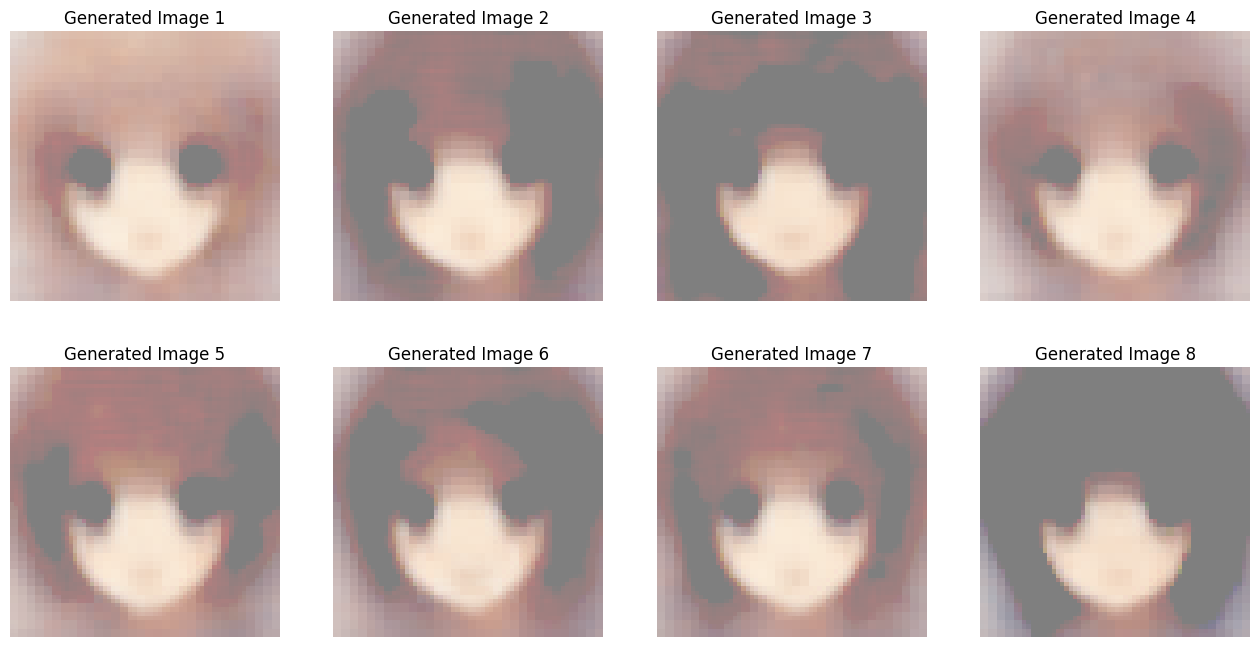

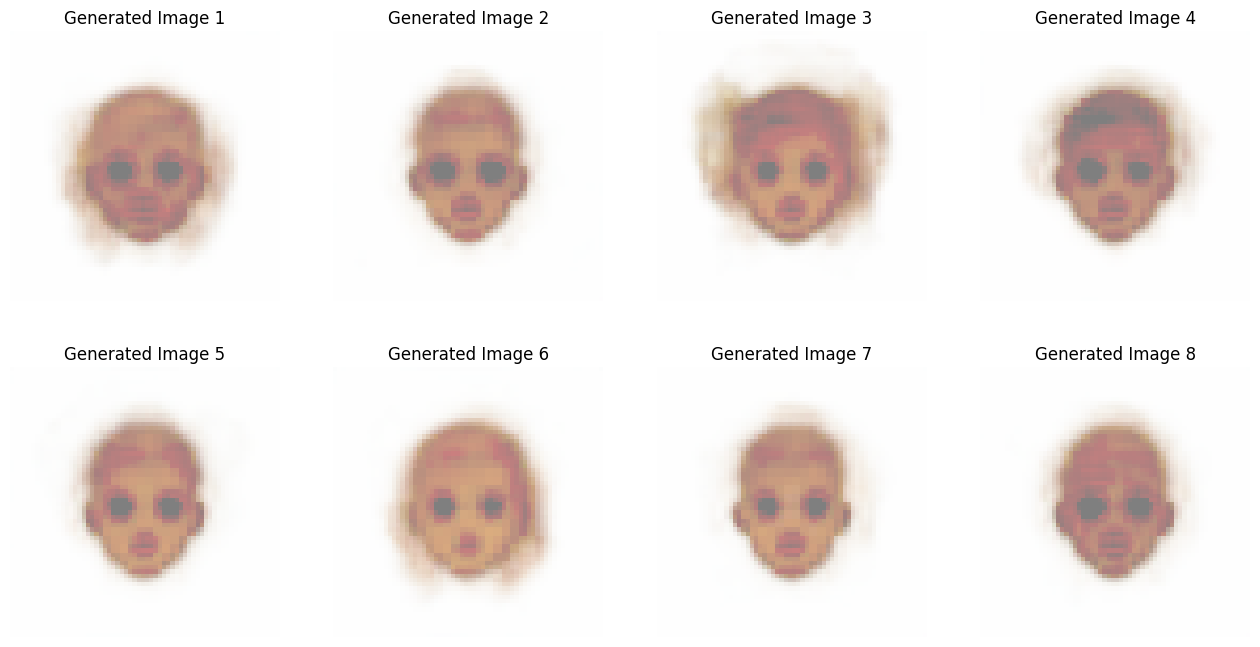

In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_images(model, label, n_times=8):
    model.eval()
    plt.figure(figsize=(16, 8))  
    with torch.no_grad():
        for i in range(n_times):
            z = torch.randn(1, latent_dim).to(device)
            label_tensor = torch.tensor(label).unsqueeze(0).to(device)
            
            generated_image = model.decoder(z, label_tensor)
            generated_image = generated_image.squeeze(0).cpu().detach().numpy()
        
            generated_image = np.clip(generated_image, 0, 1)
            
            ax = plt.subplot(2, 4, i + 1) 
            plt.imshow(np.transpose(generated_image, (1, 2, 0)))
            plt.axis('off')
            plt.title(f'Generated Image {i + 1}')
        plt.show()

# Generate 8 images with label 0 (anime face) or 1 (cartoon face)
generate_images(model, 0, n_times=8)  # Generate 8 anime faces
generate_images(model, 1, n_times=8)  # Generate 8 cartoon faces


---------------------------------------------------------------------------------------------------------------------------